In [2]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import platform
if platform.system() == "Windows":
    plt.rcParams['font.family'] = ['SimHei'] # Windows
elif platform.system() == "Darwin":
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # MacOS
plt.rcParams['axes.unicode_minus']=False 

df = pd.read_csv(r"../data/repositories_merged.csv")

In [3]:
data = df.copy()

In [4]:
# 字符串标签转换为数字编码，以便于后续模型处理
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()

df['primaryLanguage'] = lbe.fit_transform(df['primaryLanguage'])

In [5]:
df['isArchived'] = df['isArchived'].astype(int)

In [6]:
features = ['stargazerCount', 'isArchived', 'primaryLanguage',
       'total_commits', 'total_issues',
       'total_prs', 'total_stars', 'total_tags', 'total_comments',
       'average_commits', 'average_issues', 'average_prs', 'average_stars',
       'average_tags', 'average_comments']

target = 'active_lifetime'

Epoch [1/1000], Loss: 6593061.0467, Val R2: -4.1955
Epoch [10/1000], Loss: 1421235.9942, Val R2: -0.0766
Epoch [20/1000], Loss: 1158438.2317, Val R2: 0.1138
Epoch [30/1000], Loss: 1026141.8233, Val R2: 0.2222
Epoch [40/1000], Loss: 938328.3017, Val R2: 0.2803
Epoch [50/1000], Loss: 896293.0275, Val R2: 0.3129
Epoch [60/1000], Loss: 869576.5067, Val R2: 0.3328
Epoch [70/1000], Loss: 831595.7183, Val R2: 0.3503
Epoch [80/1000], Loss: 830511.7571, Val R2: 0.3648
Epoch [90/1000], Loss: 833471.8246, Val R2: 0.3774
Epoch [100/1000], Loss: 800544.7892, Val R2: 0.3892
Epoch [110/1000], Loss: 793605.4354, Val R2: 0.4001
Epoch [120/1000], Loss: 775406.1958, Val R2: 0.4104
Epoch [130/1000], Loss: 760251.0458, Val R2: 0.4209
Epoch [140/1000], Loss: 765622.9658, Val R2: 0.4302
Epoch [150/1000], Loss: 749260.6067, Val R2: 0.4406
Epoch [160/1000], Loss: 723890.8700, Val R2: 0.4506
Epoch [170/1000], Loss: 714393.0675, Val R2: 0.4607
Epoch [180/1000], Loss: 730941.3275, Val R2: 0.4703
Epoch [190/1000],

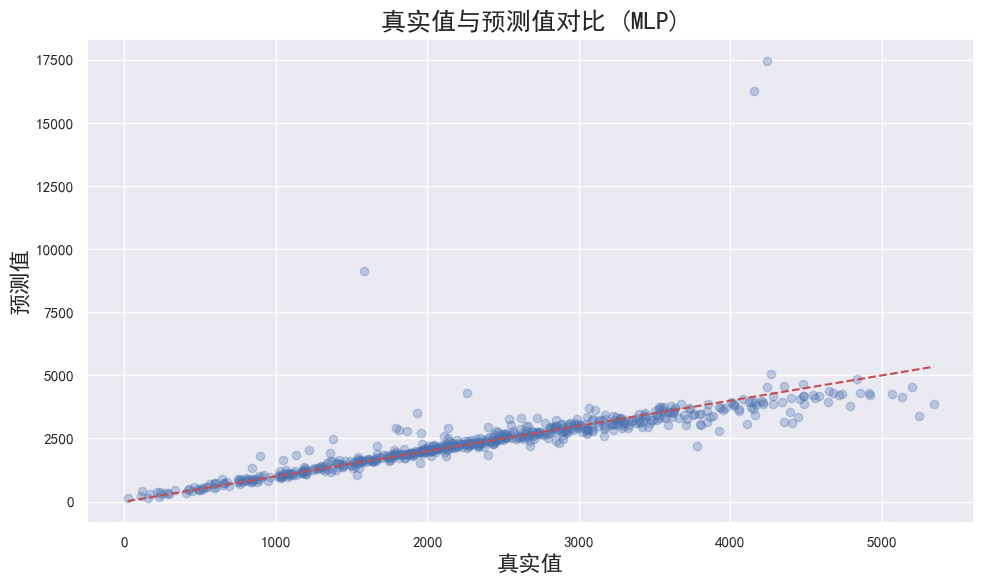

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_sample = df.sample(n=3000, random_state=42)

# 定义特征矩阵 X 和目标向量 y
X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 拆分训练集和测试集（80%/20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=50, shuffle=True
)

# 创建自定义 Dataset
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1)  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 定义神经网络模型
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim1=100, hidden_dim2=50, dropout_rate=0.1):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# 训练函数
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

      
        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")

    # 加载最佳模型
    model.load_state_dict(best_model_state)
    return model, best_r2

# 评估函数
def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  


input_dim = X_train.shape[1]
model = MLPRegressor(input_dim=input_dim, hidden_dim1=100, hidden_dim2=50, dropout_rate=0.1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 1000

trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")

# 评估模型
trained_model.eval()
trained_model.to(device)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)


plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (MLP)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_pytorch_nn.jpg", dpi=500)
plt.show()


Epoch [1/600], Loss: 6579934.3911, Val R2: -4.2270
Epoch [10/600], Loss: 1450219.2533, Val R2: -0.0959
Epoch [20/600], Loss: 1324723.8961, Val R2: 0.0017
Epoch [30/600], Loss: 1288327.9678, Val R2: 0.0535
Epoch [40/600], Loss: 1245255.0467, Val R2: 0.0913
Epoch [50/600], Loss: 1191687.6761, Val R2: 0.1195
Epoch [60/600], Loss: 1160376.8800, Val R2: 0.1539
Epoch [70/600], Loss: 1070082.1425, Val R2: 0.1881
Epoch [80/600], Loss: 972062.8761, Val R2: 0.3075
Epoch [90/600], Loss: 825908.2274, Val R2: 0.3605
Epoch [100/600], Loss: 738744.7167, Val R2: 0.4830
Epoch [110/600], Loss: 619414.0033, Val R2: 0.5610
Epoch [120/600], Loss: 493657.0482, Val R2: 0.6390
Epoch [130/600], Loss: 405316.9169, Val R2: 0.7083
Epoch [140/600], Loss: 352811.7620, Val R2: 0.7409
Epoch [150/600], Loss: 303965.5082, Val R2: 0.7805
Epoch [160/600], Loss: 266815.5410, Val R2: 0.8239
Epoch [170/600], Loss: 253955.4561, Val R2: 0.8199
Epoch [180/600], Loss: 230512.5429, Val R2: 0.8401
Epoch [190/600], Loss: 210583.25

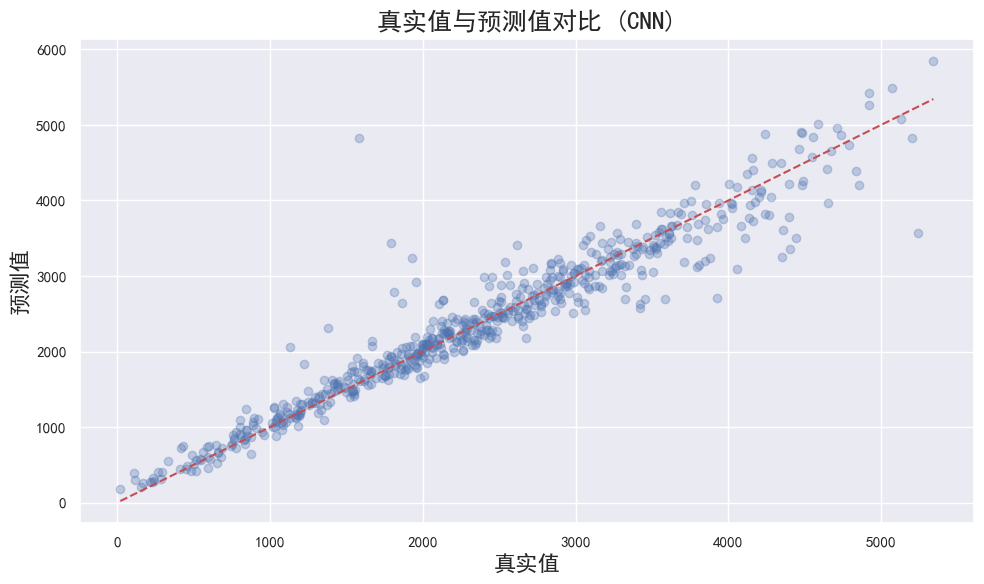

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_sample = df.sample(n=3000, random_state=42)


X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=50, shuffle=True
)


class RegressionDataset(Dataset):
    def __init__(self, X, y):
      
        self.X = torch.from_numpy(X).float().unsqueeze(1)  
        self.y = torch.from_numpy(y).float().unsqueeze(1)  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 定义CNN回归模型
class CNNRegressor(nn.Module):
    def __init__(self, input_length):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
      
        pooled_length = input_length // 4  

        self.fc1 = nn.Linear(32 * pooled_length, 100)  
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(100, 50)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(50, 1)  

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

       
        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")

   
    model.load_state_dict(best_model_state)
    return model, best_r2


def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=50, shuffle=True
)


train_dataset = RegressionDataset(X_train, y_train)
val_dataset = RegressionDataset(X_val, y_val)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


input_length = X_train.shape[1] 
model = CNNRegressor(input_length=input_length)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 600

trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")


trained_model.eval()
trained_model.to(device)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)

# 可视化真实值与预测值的对比
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (CNN)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_pytorch_cnn.jpg", dpi=500)
plt.show()


Epoch [1/1000], Loss: 6599619.9333, Val R2: -4.2145
Epoch [10/1000], Loss: 6290659.1733, Val R2: -3.9588
Epoch [20/1000], Loss: 5988385.0633, Val R2: -3.7221
Epoch [30/1000], Loss: 5705387.0967, Val R2: -3.4983
Epoch [40/1000], Loss: 5434716.9833, Val R2: -3.2857
Epoch [50/1000], Loss: 5195120.2167, Val R2: -3.0971
Epoch [60/1000], Loss: 4971193.6767, Val R2: -2.9206
Epoch [70/1000], Loss: 4757524.3567, Val R2: -2.7522
Epoch [80/1000], Loss: 4551990.0033, Val R2: -2.5900
Epoch [90/1000], Loss: 4353700.3567, Val R2: -2.4335
Epoch [100/1000], Loss: 4162269.8367, Val R2: -2.2824
Epoch [110/1000], Loss: 3977466.5200, Val R2: -2.1365
Epoch [120/1000], Loss: 3799082.0483, Val R2: -1.9959
Epoch [130/1000], Loss: 3627097.4667, Val R2: -1.8601
Epoch [140/1000], Loss: 3461344.2233, Val R2: -1.7295
Epoch [150/1000], Loss: 3301923.2000, Val R2: -1.6036
Epoch [160/1000], Loss: 3148797.8433, Val R2: -1.4829
Epoch [170/1000], Loss: 3001598.0267, Val R2: -1.3668
Epoch [180/1000], Loss: 2860522.2717, V

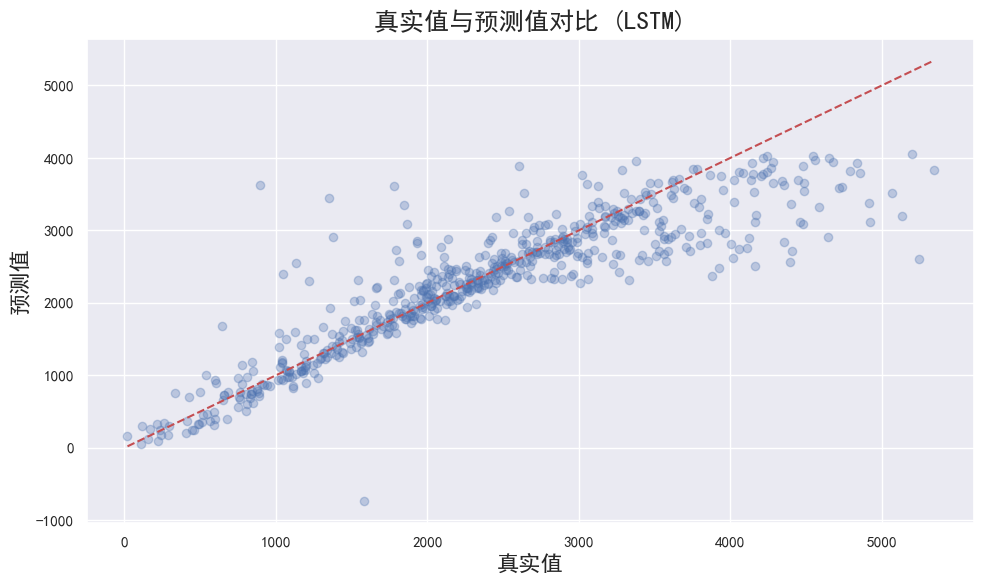

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_sample = df.sample(n=3000, random_state=42)


X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values


scaler = StandardScaler()
X = scaler.fit_transform(X)


X = X.reshape(X.shape[0], 1, X.shape[1])  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=50, shuffle=True
)


class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, num_layers=1, dropout_rate=0.1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1)  

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        out = self.fc(lstm_out[:, -1, :])  
        return out

# 训练函数
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        
        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")

  
    model.load_state_dict(best_model_state)
    return model, best_r2


def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  


input_dim = X_train.shape[2]  
model = LSTMRegressor(input_dim=input_dim, hidden_dim=100, num_layers=1, dropout_rate=0.1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 1000

trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")


trained_model.eval()
trained_model.to(device)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)


plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (LSTM)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_lstm.jpg", dpi=500)
plt.show()


Epoch [1/1000], Loss: 6597617.0133, Val R2: -4.2099
Epoch [10/1000], Loss: 6197007.6933, Val R2: -3.8800
Epoch [20/1000], Loss: 5792306.5667, Val R2: -3.5641
Epoch [30/1000], Loss: 5460708.7467, Val R2: -3.3038
Epoch [40/1000], Loss: 5157792.2033, Val R2: -3.0652
Epoch [50/1000], Loss: 4873105.9167, Val R2: -2.8407
Epoch [60/1000], Loss: 4602746.7100, Val R2: -2.6276
Epoch [70/1000], Loss: 4345047.9833, Val R2: -2.4245
Epoch [80/1000], Loss: 4099095.5800, Val R2: -2.2304
Epoch [90/1000], Loss: 3864345.5700, Val R2: -2.0454
Epoch [100/1000], Loss: 3640543.7667, Val R2: -1.8688
Epoch [110/1000], Loss: 3427515.5767, Val R2: -1.7009
Epoch [120/1000], Loss: 3225164.0933, Val R2: -1.5415
Epoch [130/1000], Loss: 3033273.1033, Val R2: -1.3902
Epoch [140/1000], Loss: 2851368.0433, Val R2: -1.2467
Epoch [150/1000], Loss: 2679518.3517, Val R2: -1.1113
Epoch [160/1000], Loss: 2517699.6833, Val R2: -0.9837
Epoch [170/1000], Loss: 2365818.1217, Val R2: -0.8641
Epoch [180/1000], Loss: 2223445.5767, V

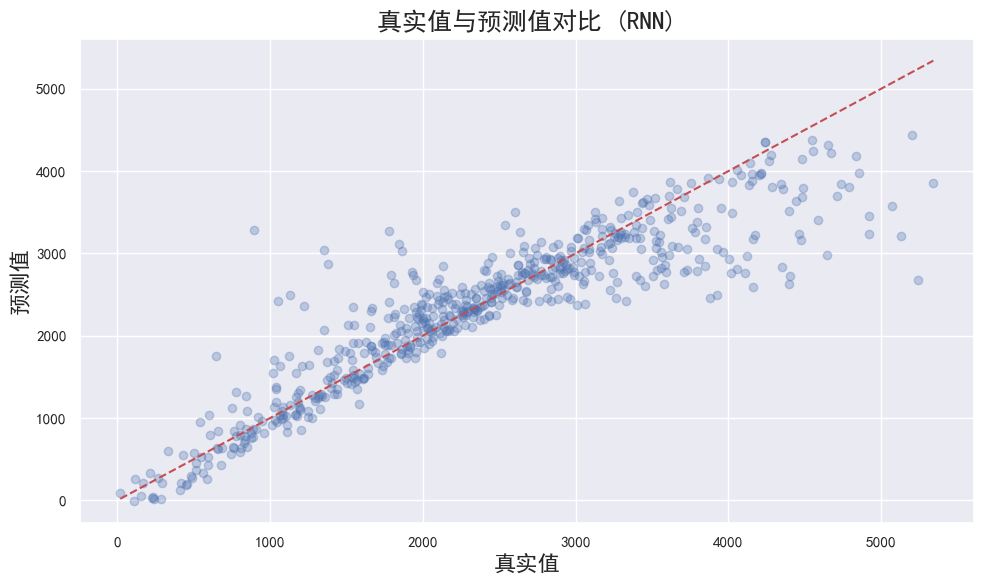

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_sample = df.sample(n=3000, random_state=42)


X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values


scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], 1, X.shape[1])  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=50, shuffle=True
)


class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 定义RNN模型
class RNNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, num_layers=1, dropout_rate=0.1):
        super(RNNRegressor, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1) 

    def forward(self, x):
        rnn_out, _ = self.rnn(x)  
        out = self.fc(rnn_out[:, -1, :]) 
        return out

# 训练函数
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # 验证阶段
        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")


    model.load_state_dict(best_model_state)
    return model, best_r2


def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  


input_dim = X_train.shape[2]  
model = RNNRegressor(input_dim=input_dim, hidden_dim=100, num_layers=1, dropout_rate=0.1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 1000

trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")


trained_model.eval()
trained_model.to(device)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)


plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (RNN)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_rnn.jpg", dpi=500)
plt.show()


Epoch [1/800], Loss: 6569182.3933, Val R2: -4.1797
Epoch [10/800], Loss: 5765635.4233, Val R2: -3.4995
Epoch [20/800], Loss: 4063236.7533, Val R2: -2.1399
Epoch [30/800], Loss: 2470475.0817, Val R2: -0.8994
Epoch [40/800], Loss: 1473071.6017, Val R2: -0.1535
Epoch [50/800], Loss: 825034.2142, Val R2: 0.3841
Epoch [60/800], Loss: 509572.5833, Val R2: 0.5262
Epoch [70/800], Loss: 363277.6115, Val R2: 0.7430
Epoch [80/800], Loss: 318385.5807, Val R2: 0.7939
Epoch [90/800], Loss: 267153.0948, Val R2: 0.8366
Epoch [100/800], Loss: 231691.7500, Val R2: 0.8463
Epoch [110/800], Loss: 201414.9477, Val R2: 0.8651
Epoch [120/800], Loss: 161312.7487, Val R2: 0.8516
Epoch [130/800], Loss: 178905.5872, Val R2: 0.8880
Epoch [140/800], Loss: 165448.6593, Val R2: 0.8749
Epoch [150/800], Loss: 168408.3741, Val R2: 0.8913
Epoch [160/800], Loss: 196172.8709, Val R2: 0.8149
Epoch [170/800], Loss: 162657.2482, Val R2: 0.8793
Epoch [180/800], Loss: 160000.1667, Val R2: 0.9097
Epoch [190/800], Loss: 175994.72

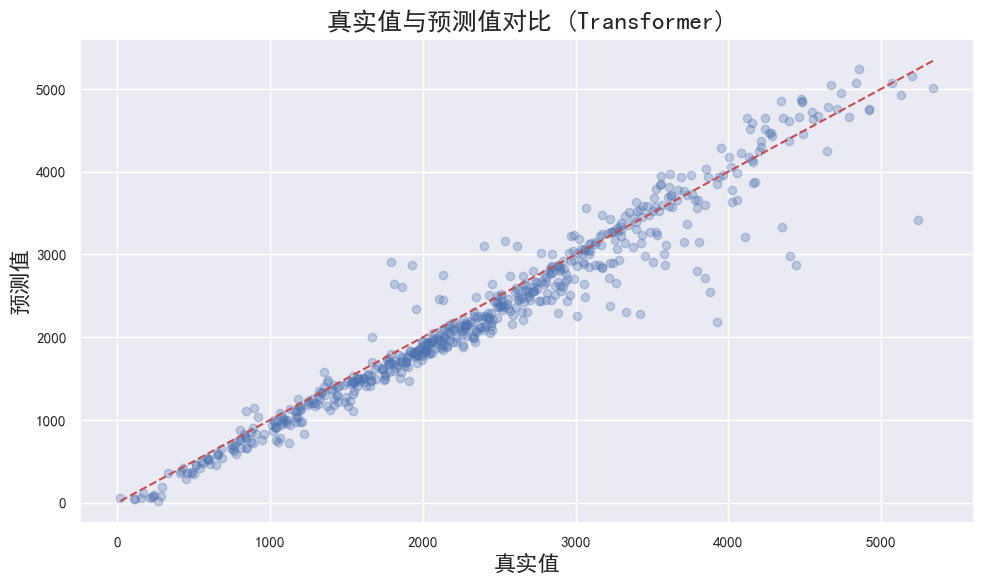

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_sample = df.sample(n=3000, random_state=42)


X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values


scaler = StandardScaler()
X = scaler.fit_transform(X)


X = X.reshape(X.shape[0], 1, X.shape[1])  

# 拆分训练集和测试集（80%/20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=50, shuffle=True
)


class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 定义 Transformer 模型
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, hidden_dim=128, dropout_rate=0.1):
        super(TransformerRegressor, self).__init__()
        self.input_dim = input_dim
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout_rate), 
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1) 

    def forward(self, x):
        x = self.embedding(x)  
        x = self.transformer(x)  
        out = self.fc(x[:, -1, :]) 
        return out


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        
        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")

    
    model.load_state_dict(best_model_state)
    return model, best_r2


def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  


input_dim = X_train.shape[2]  
model = TransformerRegressor(input_dim=input_dim, num_heads=4, num_layers=2, hidden_dim=64, dropout_rate=0.1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 800

trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")


trained_model.eval()
trained_model.to(device)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (Transformer)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_transformer.jpg", dpi=500)
plt.show()


Using device: cuda
Epoch [1/1200], Loss: 6646228.2076, Val R2: -4.9160
Epoch [10/1200], Loss: 5990566.2581, Val R2: -4.2736
Epoch [20/1200], Loss: 4540510.6024, Val R2: -2.9268
Epoch [30/1200], Loss: 3002728.5886, Val R2: -1.5306
Epoch [40/1200], Loss: 1851656.4190, Val R2: -0.5001
Epoch [50/1200], Loss: 1219317.9879, Val R2: 0.0130
Epoch [60/1200], Loss: 766135.6120, Val R2: 0.3934
Epoch [70/1200], Loss: 660495.2644, Val R2: 0.2224
Epoch [80/1200], Loss: 473693.4727, Val R2: 0.2953
Epoch [90/1200], Loss: 417074.5792, Val R2: -0.1080
Epoch [100/1200], Loss: 331050.8721, Val R2: -0.0076
Epoch [110/1200], Loss: 343125.3315, Val R2: 0.2664
Epoch [120/1200], Loss: 272952.8733, Val R2: -0.1238
Epoch [130/1200], Loss: 283643.5037, Val R2: 0.6176
Epoch [140/1200], Loss: 273741.8414, Val R2: -0.1815
Epoch [150/1200], Loss: 234863.5260, Val R2: -0.1750
Epoch [160/1200], Loss: 231846.8743, Val R2: 0.1996
Epoch [170/1200], Loss: 208106.1040, Val R2: 0.4153
Epoch [180/1200], Loss: 240793.1592, Val

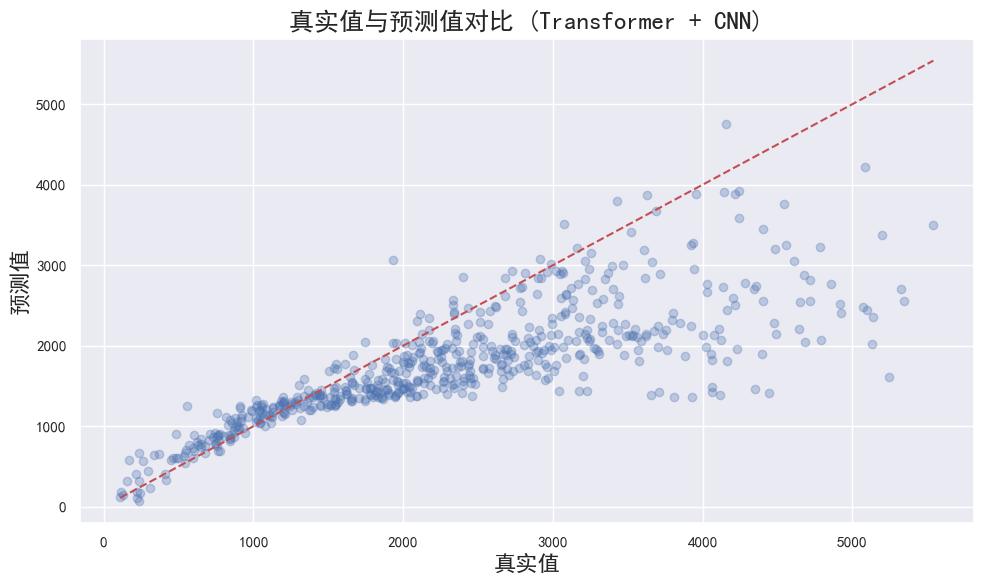

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_sample = df.sample(n=3000, random_state=42)

X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values

scaler = StandardScaler()
X = scaler.fit_transform(X)


X = X.reshape(X.shape[0], 1, X.shape[1])  


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=50, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=50, shuffle=True
)

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class TransformerCNNRegressor(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, hidden_dim=64, dropout_rate=0.1, cnn_channels=32, kernel_size=3):
        super(TransformerCNNRegressor, self).__init__()
        self.input_dim = input_dim
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=cnn_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels*2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(cnn_channels*2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
      
        self.seq_length = input_dim // 4 
        
      
        self.embedding = nn.Linear(cnn_channels*2, hidden_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout_rate), 
            num_layers=num_layers
        )
        
       
        self.fc = nn.Linear(hidden_dim, 1) 

    def forward(self, x):
      
        x = self.cnn(x)  
        x = x.permute(0, 2, 1)  
        x = self.embedding(x)  
        x = x.permute(1, 0, 2) 
        x = self.transformer(x)  
        x = x.permute(1, 0, 2) 
        out = self.fc(x[:, -1, :]) 
        return out

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu', patience=20):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, best_r2

def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


train_dataset = RegressionDataset(X_train, y_train)
val_dataset = RegressionDataset(X_val, y_val)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


input_dim = X_train.shape[2]  
model = TransformerCNNRegressor(
    input_dim=input_dim, 
    num_heads=4, 
    num_layers=2, 
    hidden_dim=64, 
    dropout_rate=0.1, 
    cnn_channels=32, 
    kernel_size=3
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Determine the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set number of epochs
num_epochs = 1200
patience = 505  


trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device, patience=patience
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")


trained_model.eval()
trained_model.to(device)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)

# Plotting the results
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (Transformer + CNN)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_transformer_cnn.jpg", dpi=500)
plt.show()


Epoch [1/800], Loss: 6571342.8400, Val R2: -4.1811
Epoch [10/800], Loss: 5768757.8667, Val R2: -3.5021
Epoch [20/800], Loss: 4066105.4500, Val R2: -2.1418
Epoch [30/800], Loss: 2451502.3017, Val R2: -0.8842
Epoch [40/800], Loss: 1414499.7017, Val R2: -0.0734
Epoch [50/800], Loss: 777939.3213, Val R2: 0.4033
Epoch [60/800], Loss: 449753.4244, Val R2: 0.6394
Epoch [70/800], Loss: 321649.6319, Val R2: 0.7542
Epoch [80/800], Loss: 268265.4272, Val R2: 0.7342
Epoch [90/800], Loss: 215596.6054, Val R2: 0.8557
Epoch [100/800], Loss: 201337.2870, Val R2: 0.8769
Epoch [110/800], Loss: 161581.4879, Val R2: 0.8680
Epoch [120/800], Loss: 132035.4558, Val R2: 0.9146
Epoch [130/800], Loss: 169375.5522, Val R2: 0.9233
Epoch [140/800], Loss: 134830.2195, Val R2: 0.9157
Epoch [150/800], Loss: 139698.4988, Val R2: 0.8913
Epoch [160/800], Loss: 167695.7460, Val R2: 0.9086
Epoch [170/800], Loss: 146173.3284, Val R2: 0.9150
Epoch [180/800], Loss: 165115.6121, Val R2: 0.7838
Epoch [190/800], Loss: 98305.371

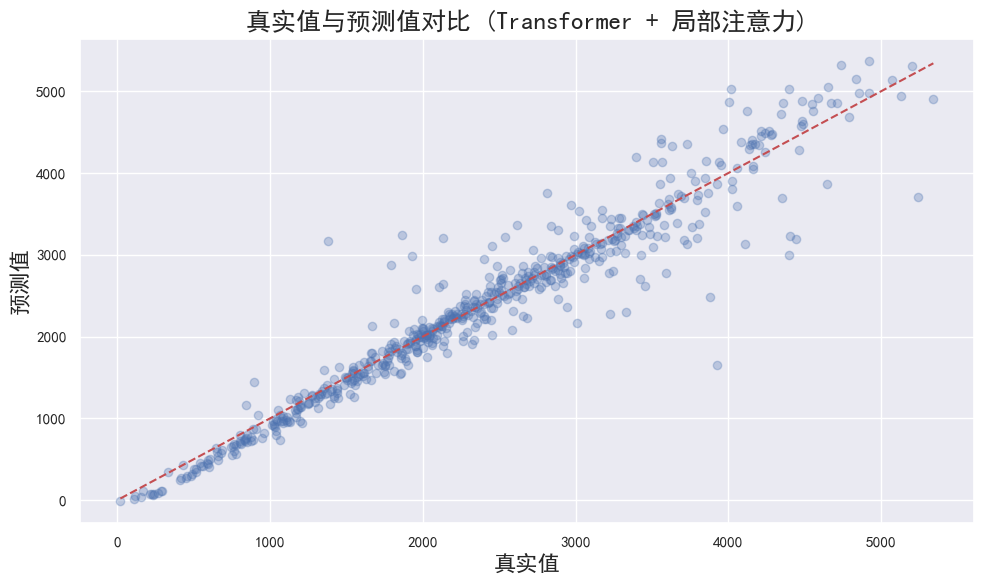

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_sample = df.sample(n=3000, random_state=42)

X = df_sample[features].astype(float).values
y = df_sample[target].astype(float).values
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], 1, X.shape[1])  

# 拆分训练集和测试集（80%/20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=50, shuffle=True
)

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, hidden_dim=64, dropout_rate=0.1, window_size=10):
        super(TransformerRegressor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.window_size = window_size  # 定义局部窗口大小
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1) 

    def generate_local_attention_mask(self, seq_len):
      
        mask = torch.full((seq_len, seq_len), float('-inf'))
        for i in range(seq_len):
           
            start = max(0, i - self.window_size)
            end = min(seq_len, i + self.window_size + 1)
            mask[i, start:end] = 0
        return mask

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  
        x = x.permute(1, 0, 2)  
        
        # 生成注意力掩码
        mask = self.generate_local_attention_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=mask) 
        
        x = x.permute(1, 0, 2)  
        out = self.fc(x[:, -1, :]) 
        return out

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, device='cpu'):
    model.to(device)
    best_r2 = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_targets = []
        val_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_targets.extend(targets.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        val_r2 = r2_score(val_targets, val_predictions)

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val R2: {val_r2:.4f}")

    model.load_state_dict(best_model_state)
    return model, best_r2

def evaluate_regression(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)
    return metrics


train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  


input_dim = X_train.shape[2]  
model = TransformerRegressor(input_dim=input_dim, num_heads=4, num_layers=2, hidden_dim=64, dropout_rate=0.1, window_size=10)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 800


trained_model, best_val_r2 = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device
)

print(f"最佳验证 R2 分数: {best_val_r2:.4f}")


trained_model.eval()
trained_model.to(device)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

metrics_test = evaluate_regression(y_test, np.array(y_pred_test).flatten())

print("测试集评估指标：")
print(metrics_test)


plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('真实值', fontsize=16)
plt.ylabel('预测值', fontsize=16)
plt.title('真实值与预测值对比 (Transformer + 局部注意力)', fontsize=18)
plt.tight_layout()
plt.savefig("../images/prediction/true_vs_pred_transformer_local_attention.jpg", dpi=500)
plt.show()
